<a href="https://colab.research.google.com/github/aviraljoshi23/Disaster_Tweets/blob/main/NLP_with_disaster__tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded=files.upload()

Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


#Importing Libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Text Preprocessing libraries
import nltk
nltk.download('stopwords')
import re 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
import en_core_web_sm
nlp = en_core_web_sm.load()


from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [4]:
#Training data set
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [5]:
test.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [6]:
train['text'][152]

'This is unbelievably insane.\n#man #airport #airplane #aircraft #aeroplane #runway #accident #freaky\x89Û_ https://t.co/cezhq7CzLl'

#Exploratory Data Analysis (EDA)

Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

Checking shape of train and test datasets. Note that the test dataset does not have 'target' column.

In [7]:
print('Shape of Training data:-',train.shape)
print('Shape of Test data:-',test.shape) 

Shape of Training data:- (7613, 5)
Shape of Test data:- (3263, 4)


Checking which all columns contain NaN values(is missing). 'location' is missing a lot in both the train and test data sets



In [8]:
#Null values
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [10]:
#train.drop(columns=['keyword','location'],axis='columns',inplace=True)
#test.drop(columns=['keyword','location'],axis='columns',inplace=True)

#Data Exploration 

In [11]:
#My target values
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [12]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [13]:
# prettier graphs!
plt.style.use('ggplot')

Text(0.5, 0, 'Target')

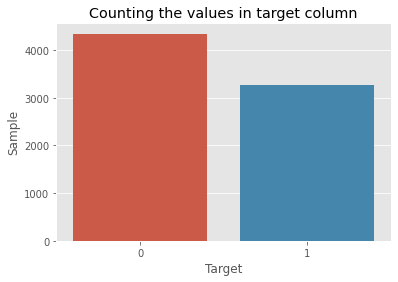

In [14]:
target_counts=train.target.value_counts()
sns.barplot(y=target_counts,x=target_counts.index)
plt.title("Counting the values in target column")
plt.ylabel('Sample')
plt.xlabel('Target')


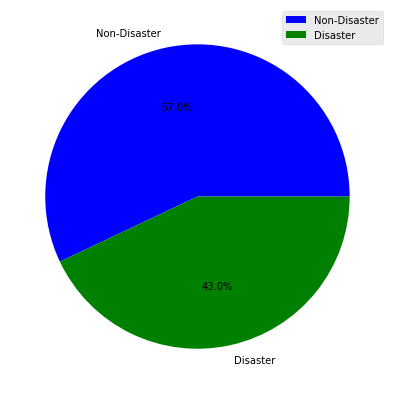

In [15]:
my_labels=['Non-Disaster','Disaster']
my_color=['B','Green']
plt.figure(figsize=(15,7))
plt.pie(train['target'].value_counts(),labels=my_labels,colors=my_color,autopct='%1.1f%%')
plt.legend()
plt.show()

In [16]:
my_disaster_tweets=train[train['target']==1]['text']
my_disaster_tweets[:10]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object

In [17]:
non_disaster_tweets=train[train['target']==0]['text']
non_disaster_tweets[:10]

15                  What's up man?
16                   I love fruits
17                Summer is lovely
18               My car is so fast
19    What a goooooooaaaaaal!!!!!!
20          this is ridiculous....
21               London is cool ;)
22                     Love skiing
23           What a wonderful day!
24                        LOOOOOOL
Name: text, dtype: object

#WordCloud

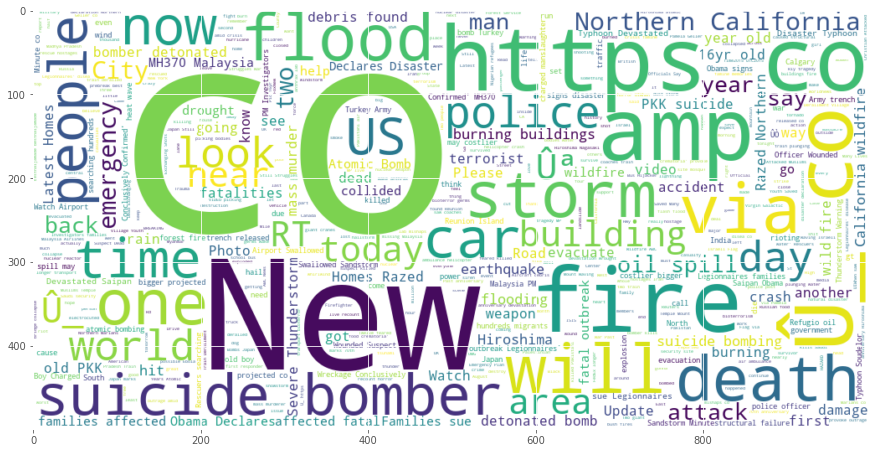

In [18]:
plt.figure(figsize=(15,10))
wc=WordCloud(max_words=500,background_color='White',width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(train[train.target==1].text))
plt.imshow(wc,interpolation='bilinear')

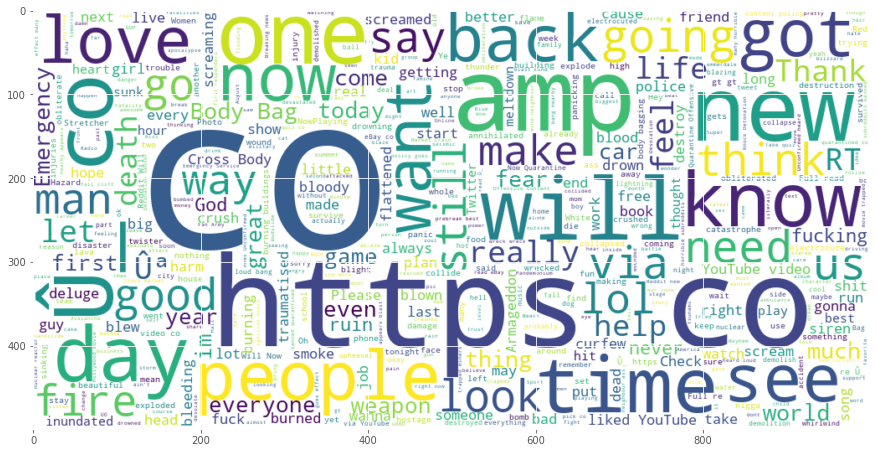

In [19]:
plt.figure(figsize=(15,10))
wc=WordCloud(max_words=500,background_color='White',width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(train[train.target==0].text))
plt.imshow(wc,interpolation='bilinear')

Let's start by analysing total number of characters in text.

#Character Length

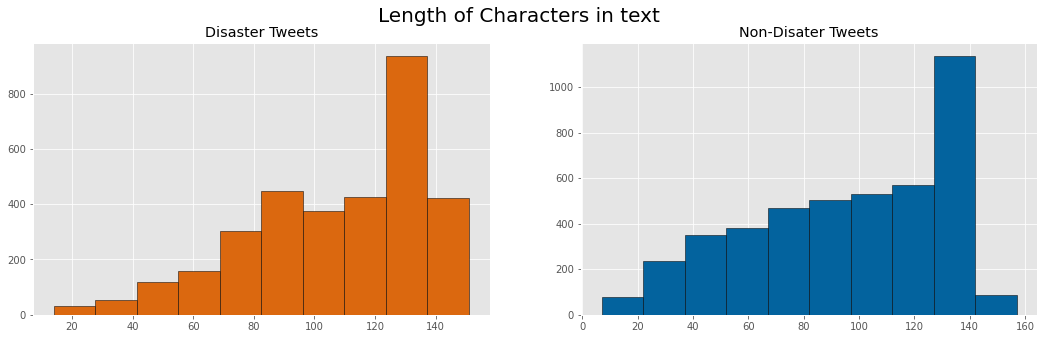

In [20]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(18,5))
char_len=train[train['target']==1]['text'].str.len()
ax1.hist(char_len,color='#db680f',edgecolor='black')
ax1.set_title('Disaster Tweets')
char_len2=train[train['target']==0]['text'].str.len()
ax2.hist(char_len2,color='#03639e',edgecolor='black')
ax2.set_title('Non-Disater Tweets')
plt.suptitle("Length of Characters in text",fontsize=20)
plt.show()

# Analysing number of words in text.

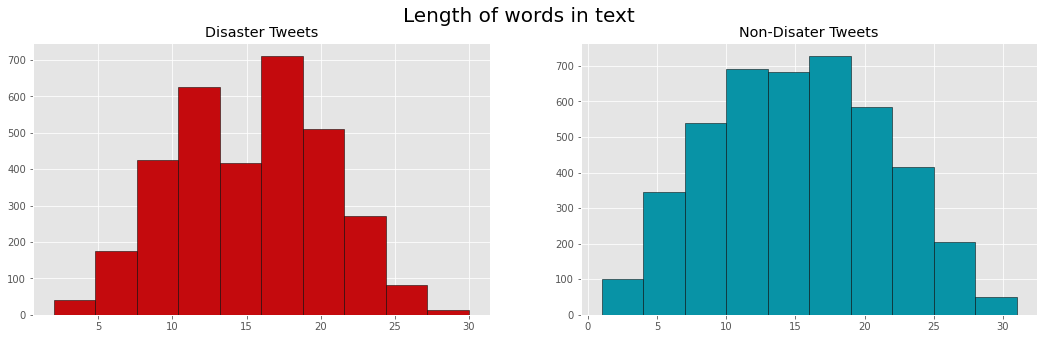

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(18,5))
char_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(char_len,color='#c40a0d',edgecolor='black')
ax1.set_title('Disaster Tweets')
char_len2=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(char_len2,color='#0893a6',edgecolor='black')
ax2.set_title('Non-Disater Tweets')
plt.suptitle("Length of words in text",fontsize=20)
plt.show()

From the above histograms, it can be observed that the words count for disaster and non-disaster tweets are in the range of (15-20).

#Average word length

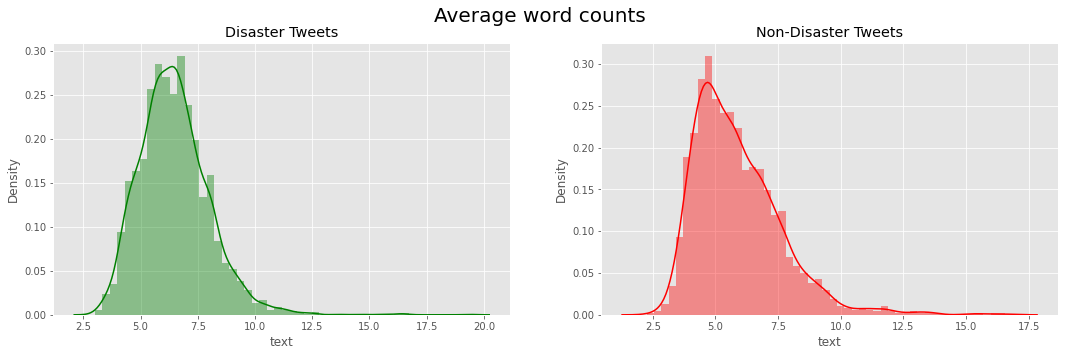

In [22]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(18,5))
char_len_dis = train[train['target']==1]['text'].str.split().apply(lambda x:  [len(i) for i in x])
sns.distplot(char_len_dis.map(lambda x: np.mean(x)),ax=ax1,color='green')
ax1.set_title("Disaster Tweets")
char_len_ndis= train[train['target']==0]['text'].str.split().apply(lambda x:  [len(i) for i in x])
sns.distplot(char_len_ndis.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title("Non-Disaster Tweets")
plt.suptitle("Average word counts",fontsize=20)
plt.show()

From the above distributions, it can be observed that the average word count for disaster tweets are found to be in the range(7-7.5) while for non-disaster tweets are in the range of (4.5-5).

**Defaultdict** is a container like dictionaries present in the module collections. Defaultdict is a sub-class of the dict class that returns a dictionary-like object. 

"**Corpus** is a large collection of texts. It is a body of written or spoken material upon which a linguistic analysis is based. "

In [23]:
def sample_corpus(target):
  corpus=[]
  for x in train[train['target']==target]['text'].str.split():
    for i in x:
      corpus.append(i)
  return corpus

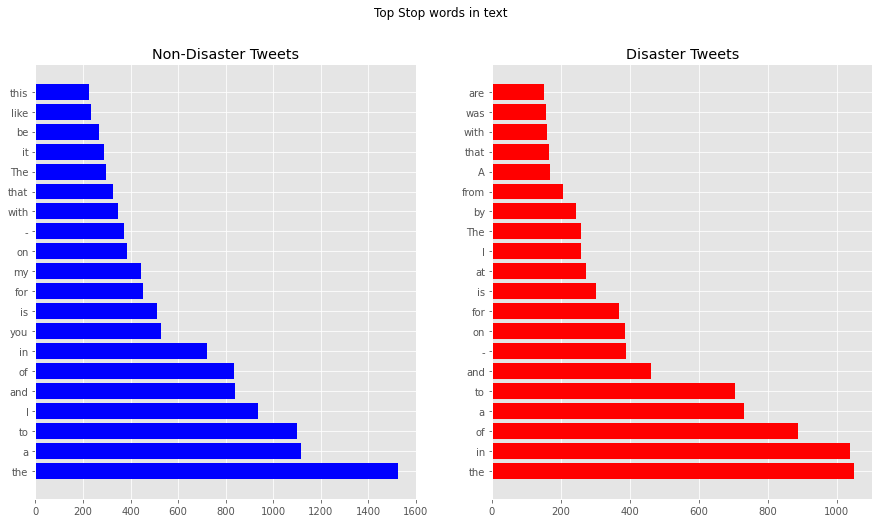

In [24]:
from collections import defaultdict

def stopwords_analysis(data,func,target):
  value_list=[]
  for labels in range(0,len(target)):
    dic=defaultdict(int)
    corpus = func(target[labels])

    for words in corpus:
      dic[words]+=1
    top=sorted(dic.items(),key=lambda x: x[1],reverse=True)[:20]
    x_items,y_values=zip(*top)
    value_list.append(x_items)
    value_list.append(y_values)

  #ploting the the figure
  fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,8))
  ax1.barh(value_list[0],value_list[1],color='b')
  ax1.set_title("Non-Disaster Tweets")

  ax2.barh(value_list[2],value_list[3],color='red')
  ax2.set_title("Disaster Tweets")

  plt.suptitle("Top Stop words in text")
  plt.show()

stopwords_analysis(train,sample_corpus,[0,1])

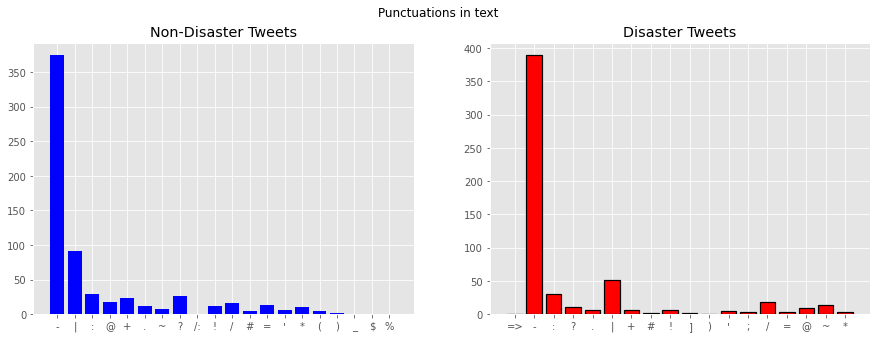

In [25]:
import string 

def punctuation_analysis(data,func,target):
    values_list = []
    special = string.punctuation
    for labels in range(0,len(target)):
        dic = defaultdict(int)
        corpus = func(target[labels])
        for i in corpus:
            if i in special:
                dic[i]+=1
        x_items,y_values = zip(*dic.items())
        values_list.append(x_items)
        values_list.append(y_values)

    #ploting the the figure
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    ax1.bar(values_list[0],values_list[1],color="b", linewidth=1.2)
    ax1.set_title("Non-Disaster Tweets")
    
    ax2.bar(values_list[2],values_list[3],color="red",edgecolor='black', linewidth=1.2)
    ax2.set_title("Disaster Tweets")
            
    plt.suptitle("Punctuations in text")
    plt.show()



punctuation_analysis(train,sample_corpus,[0,1])

The above Bar Charts displays the top 10 punctuations in tweets. From the bar chart, it is observed that the most occuring punctuation in both disaster/non-disaster tweets is "-"(350+) while the least occuring for non-disaster are "%","/:","$","_" and for disaster tweets is "=>", ")".

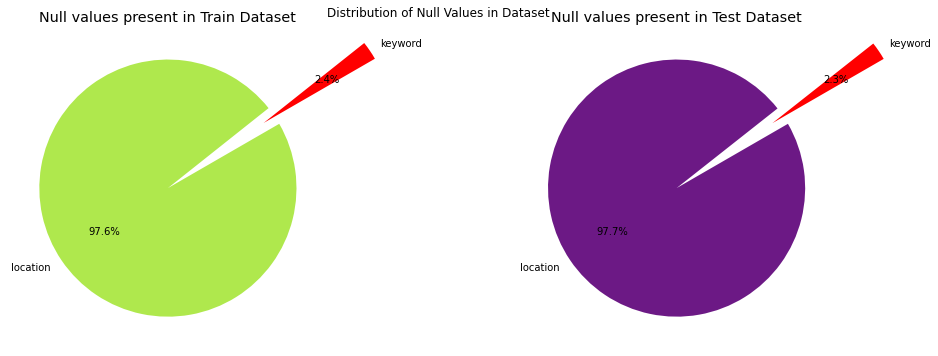

In [26]:
# Checking Null values
missing_train = train.isnull().sum()  
missing_test = test.isnull().sum()  
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
missing_train = missing_train[missing_train>0].sort_values()
ax1.pie(missing_train,autopct='%1.1f%%',startangle=30,explode=[0.9,0],labels=["keyword","location"],colors=['red','#afe84d'])
ax1.set_title("Null values present in Train Dataset")

missing_test = missing_test[missing_test>0].sort_values()
ax2.pie(missing_test,autopct='%1.1f%%',startangle=30,explode=[0.9,0],labels=["keyword","location"],colors=['Red','#6c1985'])
ax2.set_title("Null values present in Test Dataset")
plt.suptitle("Distribution of Null Values in Dataset")
plt.tight_layout()
plt.show()

In [29]:
!pip install contractions

     |████████████████████████████████| 286kB 5.2MB/s 
     |████████████████████████████████| 327kB 35.4MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85399 sha256=c06145438904b97cadb7bf0828247d572afacd5b70ae40dfe90a746dbdb46aed
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [46]:
stop_words=nltk.corpus.stopwords.words('english')
i=0
#sc=SpellChecker()
#data=pd.concat([train,test])
import contractions
from nltk.stem import SnowballStemmer
nltk.download('wordnet')
nltk.download('punkt')
wnl=WordNetLemmatizer()
stemmer=SnowballStemmer('english')
for doc in train.text:
  doc=re.sub(r'https?://\S+|www\.\S+','',doc)
  doc=re.sub(r'<.*?>','',doc)
  doc=re.sub(r'[^a-zA-Z\s]','',doc,re.I|re.A)
  #doc=' '.join([stemmer.stem(i) for i in doc.lower().split()])
  doc=' '.join([wnl.lemmatize(i) for i in doc.lower().split()])
  #doc=' '.join([sc.correction(i) for i in doc.split()])
  doc=contractions.fix(doc)
  tokens=nltk.word_tokenize(doc)
  filtered=[token for token in tokens if token not in stop_words]
  doc=' '.join(filtered)
  train.text[i]=doc
  i+=1
i=0
for doc in test.text:
  doc=re.sub(r'https?://\S+|www\.\S+','',doc)
  doc=re.sub(r'<.*?>','',doc)
  doc=re.sub(r'[^a-zA-Z\s]','',doc,re.I|re.A)
  #doc=' '.join([stemmer.stem(i) for i in doc.lower().split()])
  doc=' '.join([wnl.lemmatize(i) for i in doc.lower().split()])
  #doc=' '.join([sc.correction(i) for i in doc.split()])
  doc=contractions.fix(doc)
  tokens=nltk.word_tokenize(doc)
  filtered=[token for token in tokens if token not in stop_words]
  doc=' '.join(filtered)
  test.text[i]=doc
  i+=1

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [47]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(ngram_range=(1,1)) 

#    ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, 
#    and (2, 2) means only bigrams.

cv_matrix=cv.fit_transform(train.text).toarray()
train_df=pd.DataFrame(cv_matrix,columns=cv.get_feature_names())
test_df=pd.DataFrame(cv.transform(test.text).toarray(),columns=cv.get_feature_names())
train_df.head()

,aa,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aaceorg,aal,aampb,aampw,aan,aannnnd,aar,aaronthefm,aashiqui,ab,aba,abandon,abandonedp,abbandon,abbott,abbruchsimul,abbswinston,abbyairshow,abc,abcchicago,abceyewit,abcnew,abcnorio,abe,aberdeen,aberdeenfanpag,aberdeenfc,aberystwythshrewsburi,abha,abia,abil,abject,abl,ablaz,ableg,...,zenandemcfen,zenit,zeno,zepp,zergel,zero,zhejiang,zhenghxn,zicac,zimbabw,zimmer,zimmerman,zimpapersview,zionism,zionist,zip,ziphimup,zippednew,zipper,zippolin,ziuw,zkesk,zmne,zodiac,zojadelin,zomatoaus,zombi,zombiefunrun,zone,zonesthank,zonewolf,zoom,zotar,zouma,zourryart,zrnf,zumiez,zurich,zxatheti,zzzz
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(ngram_range=(1,1),use_idf=True)
mat=tfidf.fit_transform(train.text).toarray()
train_df=pd.DataFrame(mat,columns=tfidf.get_feature_names())
test_df=pd.DataFrame(tfidf.transform(test.text).toarray(),columns=tfidf.get_feature_names())
train_df.head()

,aa,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aaceorg,aal,aampb,aampw,aan,aannnnd,aar,aaronthefm,aashiqui,ab,aba,abandon,abandonedp,abbandon,abbott,abbruchsimul,abbswinston,abbyairshow,abc,abcchicago,abceyewit,abcnew,abcnorio,abe,aberdeen,aberdeenfanpag,aberdeenfc,aberystwythshrewsburi,abha,abia,abil,abject,abl,ablaz,ableg,...,zenandemcfen,zenit,zeno,zepp,zergel,zero,zhejiang,zhenghxn,zicac,zimbabw,zimmer,zimmerman,zimpapersview,zionism,zionist,zip,ziphimup,zippednew,zipper,zippolin,ziuw,zkesk,zmne,zodiac,zojadelin,zomatoaus,zombi,zombiefunrun,zone,zonesthank,zonewolf,zoom,zotar,zouma,zourryart,zrnf,zumiez,zurich,zxatheti,zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
model=LogisticRegression()
model.fit(train_df,train.target)
print(f1_score(model.predict(train_df),train.target))
pred=model.predict(test_df)

0.8446829922844682


In [50]:
import joblib
joblib.dump(model,'Logistic_Regression.joblib')

['Logistic_Regression.joblib']

In [37]:
pd.DataFrame({
    'id':test.id,
    'target':pred
}).to_csv('submission.csv',index=False)